# On two ways to use determinantal point processes for Monte Carlo integration

##### See [paper at ICML'19 workshop on Negative Dependence in ML](https://negative-dependence-in-ml-workshop.lids.mit.edu/wp-content/uploads/sites/29/2019/06/icml_camera_ready.pdf)

##### You can play with the different parameters :)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sampling" data-toc-modified-id="Sampling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sampling</a></span><ul class="toc-item"><li><span><a href="#Minimal-working-example" data-toc-modified-id="Minimal-working-example-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Minimal working example</a></span></li><li><span><a href="#Plot-a-sample-in-1D-or-2D" data-toc-modified-id="Plot-a-sample-in-1D-or-2D-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plot a sample in 1D or 2D</a></span></li><li><span><a href="#Timing" data-toc-modified-id="Timing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Timing</a></span></li><li><span><a href="#Rejection-bounds" data-toc-modified-id="Rejection-bounds-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Rejection bounds</a></span></li></ul></li><li><span><a href="#Numerical-integration" data-toc-modified-id="Numerical-integration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical integration</a></span><ul class="toc-item"><li><span><a href="#Estimators" data-toc-modified-id="Estimators-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Estimators</a></span></li><li><span><a href="#Integrands" data-toc-modified-id="Integrands-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Integrands</a></span></li><li><span><a href="#Estimation" data-toc-modified-id="Estimation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Estimation</a></span></li><li><span><a href="#Variance-decay" data-toc-modified-id="Variance-decay-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Variance decay</a></span><ul class="toc-item"><li><span><a href="#Of-an-integrand-$f$" data-toc-modified-id="Of-an-integrand-$f$-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Of an integrand $f$</a></span></li><li><span><a href="#$f(x)-=-\sum_{k=0}^{N_{modes}-1}-\frac{1}{k+1}-P_k(x)$" data-toc-modified-id="$f(x)-=-\sum_{k=0}^{N_{modes}-1}-\frac{1}{k+1}-P_k(x)$-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>$f(x) = \sum_{k=0}^{N_{modes}-1} \frac{1}{k+1} P_k(x)$</a></span></li></ul></li></ul></li></ul></div>

# Imports

💣 **Note:** 
- If you have not installed the package yet or
- if are using Google Colab'

please uncomment and run one of the following cells.

In [1]:
# !pip install DPPyPI

or to make sure you work with the latest release

In [2]:
# !rm -r DPPy
# !git clone https://github.com/guilgautier/DPPy.git
# !pip install scipy --upgrade
# !pip install DPPy/.

💣 If you have chosen to clone the repo and now wish to interact with the source code while running this notebook.
You can uncomment the following cell.

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.integrate import quad

import multiprocessing as mp

from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE

## Sampling

### Minimal working example

In [6]:
d, N = 2, 30  # dimension / number of points
jac_params = 0.5 - np.random.rand(d, 2)  # Jacobi ensemble parameters

dpp = MultivariateJacobiOPE(N, jac_params)
dpp.sample()

array([[ 0.16874059, -0.91309901],
       [ 0.73952902,  0.9851744 ],
       [ 0.67977868,  0.07509164],
       [-0.39539837, -0.9873811 ],
       [-0.91246988, -0.96959489],
       [ 0.29771571, -0.46043148],
       [-0.85865798,  0.99909153],
       [ 0.39269206, -0.88300668],
       [-0.40432484,  0.51633747],
       [ 0.9959337 ,  0.27160102],
       [ 0.82209134, -0.9664872 ],
       [ 0.40625632, -0.02509454],
       [ 0.94954156,  0.9515973 ],
       [ 0.42002753,  0.76748215],
       [ 0.65992176,  0.6000873 ],
       [ 0.82406505,  0.87836581],
       [ 0.29660475,  0.98188075],
       [-0.93569143, -0.76348595],
       [-0.71892567, -0.55287654],
       [-0.8040533 ,  0.28538516],
       [-0.64120916, -0.17266446],
       [-0.07053242, -0.15467422],
       [ 0.99837471,  0.75044625],
       [-0.66759055,  0.99987045],
       [-0.99483746,  0.88524368],
       [-0.98104786, -0.35400497],
       [ 0.97708532, -0.27202752],
       [ 0.22345427,  0.40482054],
       [-0.95201132,

### Plot a sample in 1D or 2D

In [7]:
d, N = 2, 100
jac_params = 0.5 - np.random.rand(d, 2)

dpp = MultivariateJacobiOPE(N, jac_params)

sampl = dpp.sample()

Display 100 points in 2D
with parameters i.i.d. uniformly on [-1/2, 1/2]^2
[[-0.45182411 -0.42225268]
 [ 0.04292491 -0.37550234]]


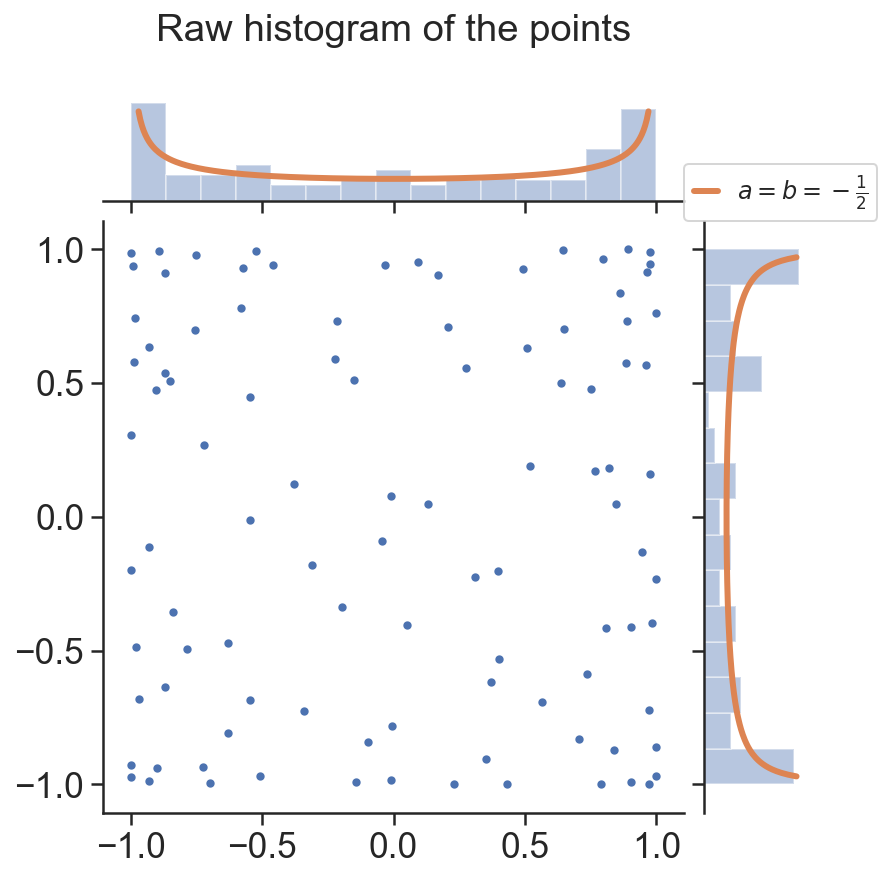

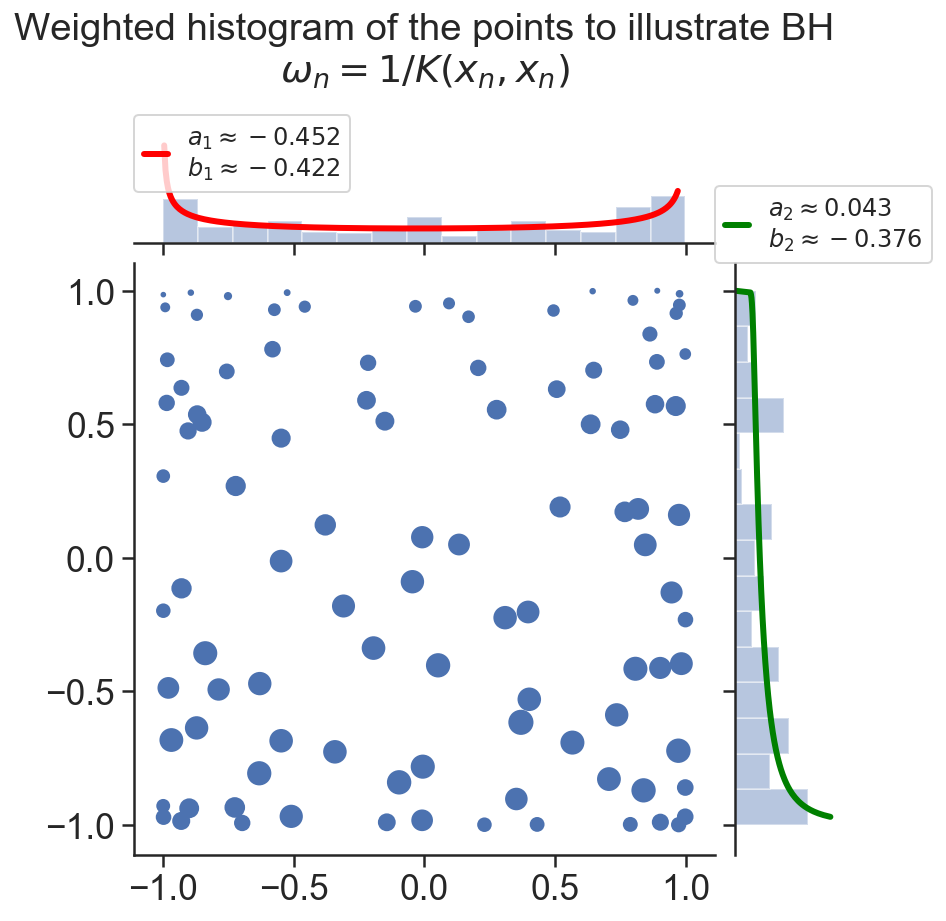

In [8]:
print('\n'.join(['Display {} points in {}D'.format(dpp.N, dpp.dim),
                 'with parameters i.i.d. uniformly on [-1/2, 1/2]^{}'.format(dpp.dim),
                 '{}'.format(jac_params)]))

if d == 1:
    
    fig, ax = plt.subplots()
    plt.title('Raw histogram of the points')
    ax.hist(sampl, density=True)
    ax.plot(X_, 0.5*stats.beta(0.5, 0.5).pdf(0.5*(1-X_)),
            label=r'$a=b=-\frac{1}{2}$')
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title('\n'.join(['Weighted histogram of the points to illustrate BH',
                         r'$\omega_n = 1/K(x_n, x_n)$']))
    ax.hist(sampl, density=True, weights=1/dpp.K(sampl))
    ax.plot(X_, 0.5*stats.beta(*(1+jac_params[0])).pdf(0.5*(1-X_)),
            label=['\n'.join([r'$a \approx {:1.3f}$'.format(jac_params[0, 0]),
                              r'$b \approx {:1.3f}$'.format(jac_params[0, 1])])])
    plt.show()
    
if d == 2:
    lab_arcsine = [r'$a=b=-\frac{1}{2}$']
    leg_prop = {'size':12}

    sns.set(context='notebook', style='ticks', palette='deep',
            font='sans-serif', font_scale=1.6, color_codes=True, rc=None)
    # raw points
    tol = 3e-2
    X_ = np.linspace(-1 + tol, 1 - tol, 300)[:, None]
    g = sns.JointGrid(sampl[:,0], sampl[:,1])

    g = g.plot_joint(plt.scatter, s=10)
    plt.title('Raw histogram of the points',
             pad=90)

    g = g.plot_marginals(sns.distplot, bins=15, norm_hist=True, kde=False)

    arcsine = 0.5*stats.beta(0.5, 0.5).pdf((1-X_)/2)
    g.ax_marg_x.plot(X_, arcsine,
                     lw=3)
    g.ax_marg_y.plot(arcsine, X_,
                     lw=3)
    
    g.ax_marg_y.legend(labels=lab_arcsine,
                       prop=leg_prop,
                       loc=(-0.2, 1),
                       handlelength=1)
    

    # weighted version
    weights = 1.0/dpp.K(sampl)  # 1.0/np.array([dpp.K(x) for x in sampl])

    g = sns.JointGrid(sampl[:,0], sampl[:,1])

    g = g.plot_joint(plt.scatter, s=1000*weights)
    
    plt.title('\n'.join(['Weighted histogram of the points to illustrate BH',
                         r'$\omega_n = 1/K(x_n, x_n)$']),
             pad=90)
    g = g.plot_marginals(sns.distplot, bins=15, norm_hist=True, kde=False, hist_kws={'weights': weights})

    tol = 30e-3
    X_ = np.linspace(-1, 1 - tol, 400)[:, None]
    g.ax_marg_x.plot(X_,
                     0.5*stats.beta(*(1+jac_params[0])).pdf(0.5*(1-X_)),
                     c='red',
                     lw=3)
    g.ax_marg_x.legend(labels=['\n'.join([r'$a_1 \approx {:1.3f}$'.format(jac_params[0, 0]),
                                          r'$b_1 \approx {:1.3f}$'.format(jac_params[0, 1])])],
                       prop=leg_prop,
                       loc=(0, 0.5),
                       handlelength=1)
    
    tol = 30e-3
    X_ = np.linspace(-1 + tol, 1, 300)[:, None]
    g.ax_marg_y.plot(0.5*stats.beta(*(1+jac_params[1])).pdf(0.5*(1-X_)),
                     X_,
                     c='green',
                     lw=3)
    g.ax_marg_y.legend(labels=['\n'.join([r'$a_2 \approx {:1.3f}$'.format(jac_params[1, 0]),
                                          r'$b_2 \approx {:1.3f}$'.format(jac_params[1, 1])])],
                       prop=leg_prop,
                       loc=(-0.2, 1),
                       handlelength=1)
    
    
#     g.savefig("sample_2D_{}_points_weighted.pdf".format(dpp.N))

### Timing

To get a quick idea of the time to get a sample you can run the following cell

In [9]:
d, N = 2, 50
jac_params = 0.5 - np.random.rand(d, 2)
# jac_params = -0.5 * np.ones((d, 2))

dpp = MultivariateJacobiOPE(N, jac_params)

%timeit dpp.sample()

178 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Rejection bounds

In [10]:
dim_max = 20
rang_dim = [1, 5, 10, 15]  #np.arange(1, 4+1)

N_start, N_max, N_step = 50, 200, 50
rang_N = [n for n in range(N_start, N_max+1, N_step)]

rej_bounds = np.zeros((3, len(rang_dim), len(rang_N)))

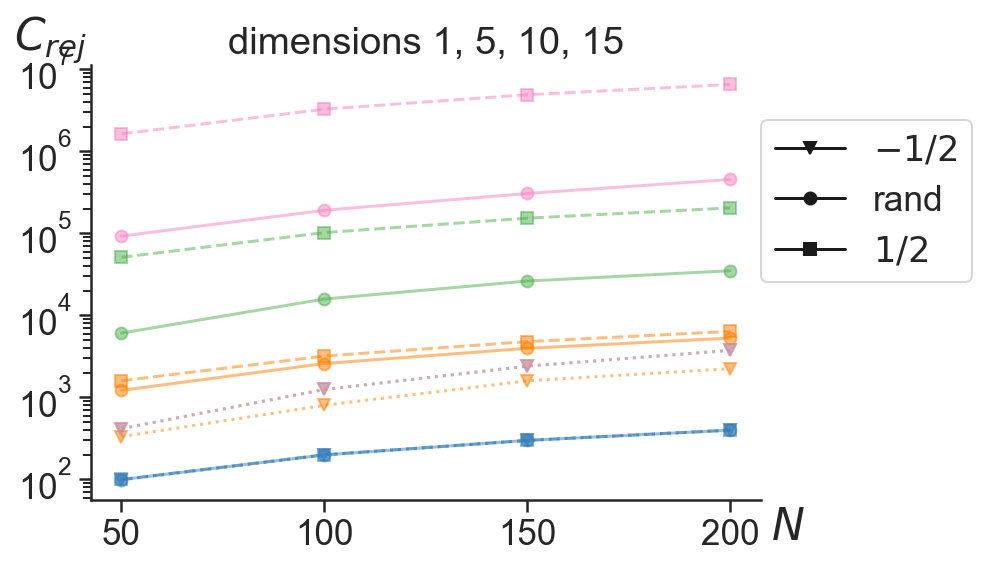

In [11]:
CB_cols = ['#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots()
plt.title('dimensions '+', '.join([str(d) for d in rang_dim]))

for d, dim in enumerate(rang_dim):
    
    jac_par_list = [-0.5*np.ones((dim, 2)),
                    0.5-np.random.rand(dim, 2),
                    0.5*np.ones((dim, 2))]
    labels = [r'$-1/2$', 'rand', r'$1/2$']
    markers = ['v', 'o', 's']
    l_style = [':', '-', '--']
    
    for jac_par, m, ls in zip(jac_par_list, markers, l_style):

#         print(jac_par)
        ax.semilogy(rang_N,
                    [MultivariateJacobiOPE(N, jac_par).rejection_bound
                         for N in rang_N],
                    marker=m,
                    ls=ls,
                    c=CB_cols[d],
                    alpha=0.5
                    )

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot([0, 0], [1, 0], label=labels[0], marker=markers[0],
        ls='-',
        c='k')  
ax.plot([0, 0], [1, 0], label=labels[1], marker=markers[1],
        ls='-',
        c='k')
ax.plot([0, 0], [1, 0], label=labels[2], marker=markers[2],
        ls='-',
        c='k')

# ax.set_xlim([49, 212])
ax.set_xlabel(r'$N$', fontsize=22)
ax.xaxis.set_label_coords(1.04, -0.02)
ax.set_ylabel(r'$C_{rej}$', fontsize=22, rotation='horizontal')
ax.yaxis.set_label_coords(-0.06, 1.)

ax.tick_params(axis = 'both', which = 'major', labelsize = 17.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc=(1.0, 0.5))
plt.show()

## Numerical integration

### Estimators

In [12]:
def BH_estimator(integrand, dpp, sample=None):
    
    if sample is not None:
        return np.sum(integrand(sample).ravel() / dpp.K(sample))
    
    else:
        sample = dpp.sample()
        return BH_estimator(integrand, dpp, sample)

def EZ_estimator(integrand, dpp, sample=None):

    if sample is not None:
        
        phi_x = dpp.eval_polys(sample)
        integrand_x = integrand(sample).ravel()

        EZ_estimator = np.linalg.solve(phi_x, integrand_x)[0]
        EZ_estimator *= np.sqrt(np.prod(dpp.square_norms[0]))
        
        return EZ_estimator#, np.linalg.cond(phi_sample)

    else:
        
        sample = dpp.sample()
        return EZ_estimator(integrand, dpp, sample)

def both_estimators(integrand, dpp, sample=None):
    
    if sample is not None:
        return BH_estimator(integrand, dpp, sample), EZ_estimator(integrand, dpp, sample)
    
    else:
        np.random.seed(None)
        sample = dpp.sample()
        return both_estimators(integrand, dpp, sample)

### Integrands

In [13]:
def bump_eps(X, eps=0.05):
    """ https://en.wikipedia.org/wiki/Bump_function
    """

    if type(X) is float:
        f_x = np.exp(-1 / (1.0 - eps - X**2)) if abs(X) < 1 - eps else 0.
        
    elif X.ndim == 1:
        in_I = np.abs(X) < 1 - eps
        f_x = np.zeros(in_I.size)
        f_x[in_I] = np.exp(-1 / (1.0 - eps - X[in_I]**2))

    else:
        in_I = np.all(np.abs(X) < 1 - eps, axis=1)
        f_x = np.zeros(in_I.size)
        f_x[in_I] = np.exp(-np.sum(1.0 / (1.0 - eps - X[in_I]**2), axis=1))
    
    return f_x

def sine(X):

    if type(X) is float: 
        f_x = np.sin(np.pi*X)
    elif X.ndim == 1:
        f_x = np.sin(np.pi*X)
    else:
        f_x = np.prod(np.sin(np.pi*X), axis=-1)
    
    return f_x

def cosine(X):

    if type(X) is float: 
        f_x = np.cos(np.pi*X)
    elif X.ndim == 1:
        f_x = np.cos(np.pi*X)
    else:
        f_x = np.prod(np.cos(np.pi*X), axis=-1)
    
    return f_x

def absolute(X):
    if type(X) is float: 
        f_x = np.abs(X)
    elif X.ndim == 1:
        f_x = np.abs(X)
    else:
        f_x = np.prod(np.abs(X), axis=-1)
    
    return f_x

def heaviside(X, shift=0):
    
    if type(X) is float: 
        f_x = np.heaviside(X - shift, 0)
    elif X.ndim == 1:
        f_x = np.heaviside(X - shift, 0)
    else:
        f_x = np.prod(np.heaviside(X - shift, 0), axis=-1)
    
    return f_x

def mix(X):
    
    return 0.5 * (heaviside(X) - 0.5) * (cosine(X) + cosine(2*X) + sine(5*X))

### Estimation

In [14]:
def integrand(x):
    return bump_eps(x, eps=0.05)
#     return cosine(x)
#     return 2 * (heaviside(x) - 0.5)
#     return absolute(x)
#     return mix(x)

In [15]:
d, N = 1, 30

jac_params = -0.5 + np.random.rand(d, 2)
# jac_params = -0.5*np.ones((d, 2))

dpp = MultivariateJacobiOPE(N, jac_params)

Estimation of the integral

BH
0.38115741240830625
EZ
0.39570762828506206
scipy quad
0.3957124991052268
numpy trapz
0.39571249910368883


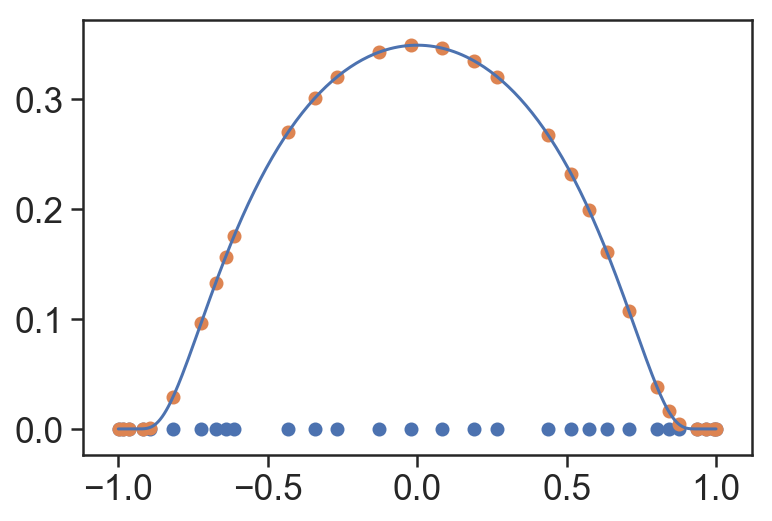

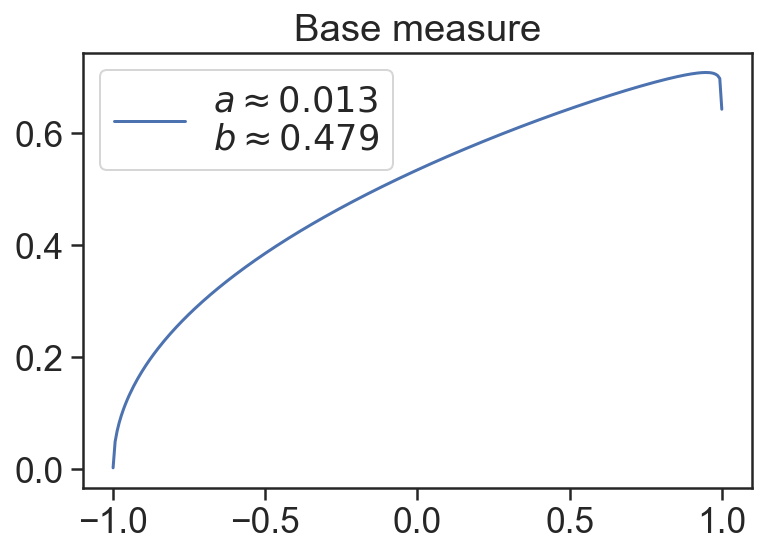

In [16]:
sampl = dpp.sample()

print('Estimation of the integral\n')
for lab, est in zip(['BH', 'EZ'], both_estimators(integrand, dpp, sampl)):
    print(lab)
    print(est)
    
if d == 1:
    
    print('scipy quad')
    print(quad(lambda x: dpp.eval_w(x)*integrand(x), 
               -1, 1)[0])

    tol = 1e-4
    X_ = np.linspace(-1 + tol, 1 - tol, 300)[:, None]

    print('numpy trapz')
    print(np.trapz(dpp.eval_w(X_)*integrand(X_),
                   X_.ravel()))
    
    
    tol = 1e-5
    X_ = np.linspace(-1 + tol, 1 - tol, 300)[:, None]
    fig, ax = plt.subplots()
    ax.plot(X_, integrand(X_), label='f')
    ax.scatter(sampl, np.zeros_like(sampl), label='sample')
    ax.scatter(sampl, integrand(sampl), label='f(sample)')
    
    plt.figure()
    plt.title('Base measure')
    plt.plot(X_, 0.5*stats.beta(*(1+jac_params[0])).pdf(0.5*(1-X_)),
             label='\n'.join([r'$a \approx {:1.3f}$'.format(jac_params[0, 0]),
                              r'$b \approx {:1.3f}$'.format(jac_params[0, 1])]))
    plt.legend()

###  Variance decay

##### To repeat the estimations, we use the package `multiprocessing` 
##### In this notebook, to estimate the variance of both BH and EZ estimators,
##### we draw $20$ samples with up to $N=100$ points for $d=1,2$ (by default)
##### You can change the parameters, but sampling may take some time

#### Of an integrand $f$

In [17]:
def integrand(x):
    return bump_eps(x, eps=0.05)
#     return cosine(x)
#     return 2 * (heaviside(x) - 0.5)
#     return absolute(x)
#     return mix(x)

In [18]:
dim_max = 2
nb_repeats = 20

var_results = dict()

for d in range(1, dim_max+1):
    print('dimension =', d)
    
    jac_params = -0.5 + np.random.rand(d, 2)
    jac_params[0, :] = -0.5
    if d == 1:
        N_min, N_max, N_step = 20, 100, 20
    else:
        N_min, N_max, N_step = 20, 100, 20
    
    var_results[(d,)] = jac_params
    
    for N in range(N_min, N_max+1, N_step):
        print('#points =', N)

        dpp = MultivariateJacobiOPE(N, jac_params)

        pool = mp.Pool(mp.cpu_count())

        results = pool.starmap(both_estimators, [(integrand, dpp) for _ in range(nb_repeats)])
        results = np.array(results)
        var_results[(d, N)] = np.var(results, axis=0)

        pool.close()

dimension = 1
#points = 20
#points = 40
#points = 60
#points = 80
#points = 100
dimension = 2
#points = 20
#points = 40
#points = 60
#points = 80
#points = 100


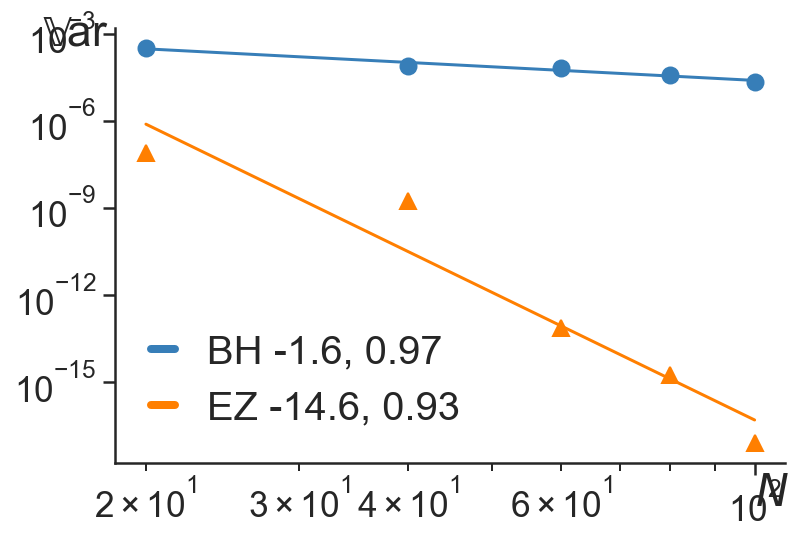

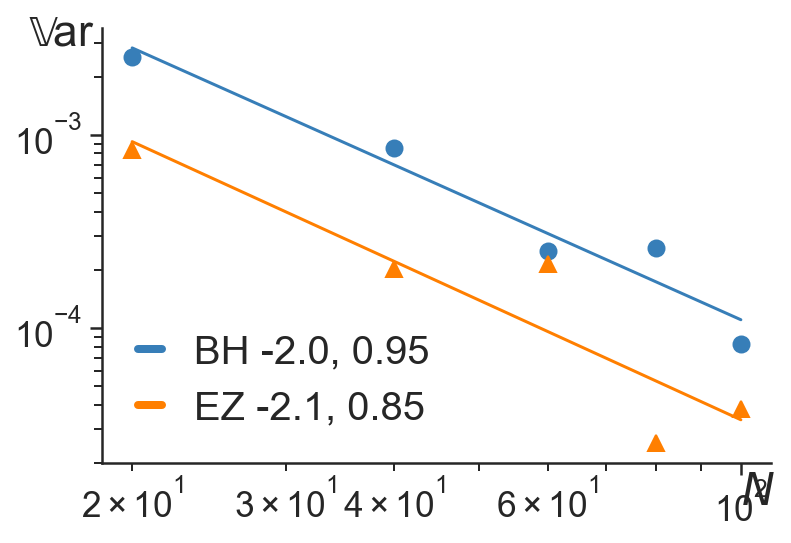

In [19]:
j_par = {d: var_results.get((d, )) for d in range(1, dim_max + 1)}
var_N = {d: np.array([key[1] for key in var_results.keys() if len(key)==2 and key[0]==d])
            for d in range(1, dim_max + 1)}
var_res = {d: np.array([value for key, value in var_results.items() if len(key)==2 and key[0]==d]).T
            for d in range(1, dim_max + 1)}

cols = ['blue', 'green']
CB_cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', '^']
labels = ['BH', 'EZ']
for d in range(1, dim_max + 1):
    
    fig, ax = plt.subplots()
#     plt.title(r'Dimension $d={}$'.format(d), fontsize=20)
    ax.set_xlabel(r'$N$', fontsize=22)
    ax.xaxis.set_label_coords(0.98, -0.025)
    ax.set_ylabel(r'$\mathrm{\mathbb{V}}$ar', fontsize=22, rotation='horizontal')
    ax.yaxis.set_label_coords(-0.06, 0.94)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 17.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    for c, m, lab, var_estim in zip(CB_cols[:2], markers, labels, var_res[d]):

        ax.loglog(var_N[d], var_estim, m, c=c, markersize=8)

        x_plot = np.array([np.min(var_N[d]), np.max(var_N[d])])
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(var_N[d]), np.log(var_estim))
        lab += r' {:.1f}, {:.2f}'.format(slope, r_value**2)
        
        ax.loglog(x_plot, np.exp(intercept)*x_plot**slope, c=c, label=lab)
    
    leg = ax.legend(fontsize=20, frameon=False, handlelength=0.6, loc='lower left')

    for line in leg.get_lines():
        line.set_linewidth(4.0)

    plt.show()

#### $f(x) = \sum_{k=0}^{N_{modes}-1} \frac{1}{k+1} P_k(x)$

$N_{modes}=70$

EZ provides perfect estimation when $N\geq N_{modes}$, see the drop in the variance plot

In [20]:
dim_max = 2
nb_repeats = 20

N_modes = 30
N_min, N_max, N_step = 10, 50, 10

var_results = dict()

for d in range(1, dim_max+1):
    print('dimension =', d)
    
    jac_params = -0.5 + np.random.rand(d, 2)
    jac_params[0, :] = -0.5
    
    dpp_gp = MultivariateJacobiOPE(N_modes, jac_params)
    coefs = 1.0 / np.arange(1, dpp_gp.N + 1)
    
    def f_gp(X):
        return np.sum(coefs*dpp_gp.eval_polys(X), axis=-1)

    var_results[(d, )] = jac_params
    
    for N in range(N_min, N_max+1, N_step):
        print('#points =', N)

        dpp = MultivariateJacobiOPE(N, jac_params)

        pool = mp.Pool(mp.cpu_count())

        results = pool.starmap(both_estimators, [(f_gp, dpp) for _ in range(nb_repeats)])
        results = np.array(results)
        var_results[(d, N)] = np.var(results, axis=0)

        pool.close()

dimension = 1
#points = 10
#points = 20
#points = 30
#points = 40
#points = 50
dimension = 2
#points = 10
#points = 20
#points = 30
#points = 40
#points = 50


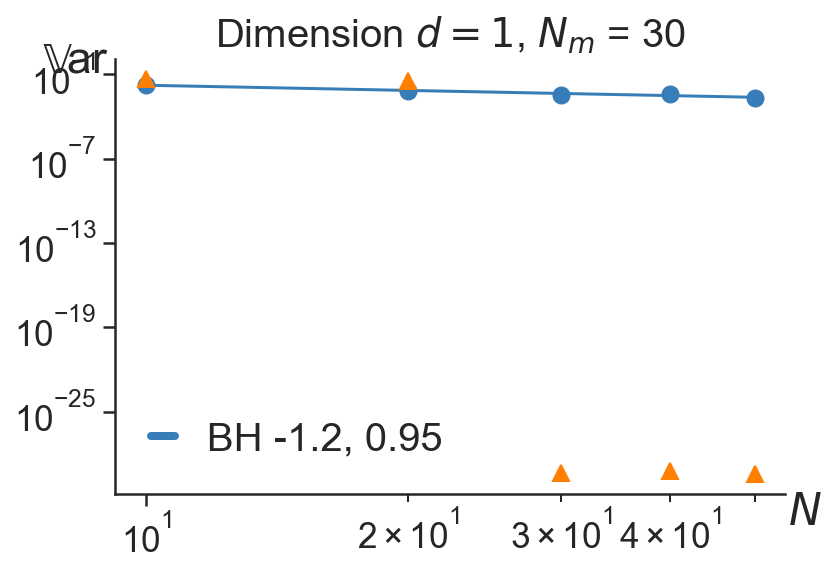

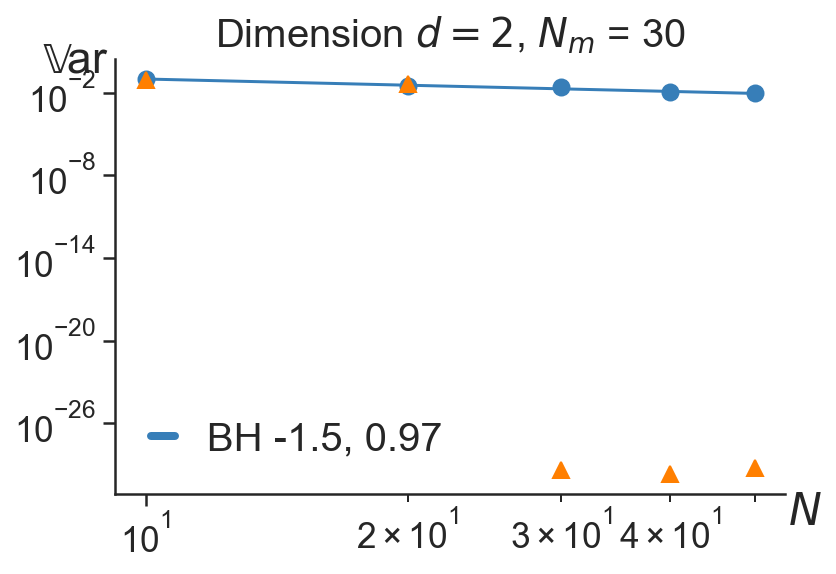

In [21]:
j_par = {d: var_results.get((d, )) for d in range(1, dim_max + 1)}
var_N = {d: np.array([key[1] for key in var_results.keys() if len(key)==2 and key[0]==d])
            for d in range(1, dim_max + 1)}
var_res = {d: np.array([value for key, value in var_results.items() if len(key)==2 and key[0]==d]).T
            for d in range(1, dim_max + 1)}


CB_cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['o', '^']
labels = ['BH', 'EZ']
for d in range(1, dim_max + 1):
    
    fig, ax = plt.subplots()
    plt.title(r'Dimension $d={}$, $N_m$ = {}'.format(d, N_modes), fontsize=20)
    ax.set_xlabel(r'$N$', fontsize=22)
    ax.xaxis.set_label_coords(1.03, -0.0)
    ax.set_ylabel(r'$\mathrm{\mathbb{V}}$ar', fontsize=22, rotation='horizontal')
    ax.yaxis.set_label_coords(-0.06, 0.95)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 17.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    for c, m, lab, var_estim in zip(CB_cols[:2], markers, labels, var_res[d]):

        ax.loglog(var_N[d], var_estim, m, c=c, markersize=8)

        x_plot = np.array([np.min(var_N[d]), np.max(var_N[d])])
        
        if lab == 'BH':
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(var_N[d]), np.log(var_estim))
            lab += r' {:.1f}, {:.2f}'.format(slope, r_value**2)
        
            ax.loglog(x_plot, np.exp(intercept)*x_plot**slope, c=c, label=lab)
        
    leg = ax.legend(fontsize=20, frameon=False, handlelength=0.6, loc='lower left')

    for line in leg.get_lines():
        line.set_linewidth(4.0)
        
    plt.show()